# GMSAT trend significance testing

To do:  
Add in pooch features  
Generalise input (i.e., change names to be the same etc.)

In [1]:
%reset -f

In [2]:
%load_ext autoreload

In [3]:
%reload_ext autoreload
%autoreload 2

In [236]:
# analysis and plotting
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import xarray as xr
from scipy.signal import butter, filtfilt
from scipy.stats import pearsonr

# stats
from scipy.stats import pearsonr

# systems
import os
from collections import defaultdict
import csv
import pooch

# plotting
import seaborn as sns
import matplotlib.colors as mcolors
import matplotlib.cm as cm

# my own functions and classes
from GMSAT_classes import Trend
from GMSAT_functions import CropTrendsDf, GenerateRN, GenerateWN, TrendsDictFromFiles, CalculateTrendPercentile, FlagInRange, DictToDf, MakeChangeDir

## Parameters

In [258]:
obsName = 'BEST'
N = 1000

### Directories

#### Input

In [259]:
inputDir = '/home/hbyrne/Research/GMSAT_JS/Input'

#### Output

In [260]:
# Trends dataframes
pathBase = f'/home/hbyrne/Research/GMSAT_JS/Output_{obsName}/'
dirTrendsRNEnd = 'TrendsRN'
dirTrendsWNEnd = 'TrendsWN'

dirTrendsRN = pathBase + dirTrendsRNEnd
dirTrendsWN = pathBase + dirTrendsWNEnd

# time series stats
dirStatsEnd = 'TimeSeriesStats'
dirStats = pathBase + dirStatsEnd

# plots
dirPlotsObs = f'/home/hbyrne/Research/GMSAT_JS/Plots/Plots_{obsName}'

## Calculating trends for real data

In [261]:
# taking a look at the file
inputFile = f'{obsName}.nc'

os.chdir(inputDir)
ds = xr.open_dataset(inputFile)

# standardising the input
if isinstance(ds.time.values[0], np.float64):
    dateIndex = pd.to_datetime(ds.time.values, format = '%Y')
    ds.coords['time'] = dateIndex

# calculating global mean sst based on this (note have to area weight the cells)
if obsName == 'GISS':
    weights = np.cos(np.radians(ds.lat))
    meanTemp = ds.tempanomaly.weighted(weights).mean(('lat', 'lon'), skipna = True)

if obsName == 'BEST':
    weights = np.cos(np.radians(ds.latitude))
    meanTemp = ds.temperature.weighted(weights).mean(('latitude', 'longitude'), skipna = True)

if obsName == 'HadCRUT':
    weights = np.cos(np.radians(ds.latitude))
    meanTemp = ds.tas_mean.weighted(weights).mean(('latitude', 'longitude'), skipna = True)

In [262]:
# aggregating to annual
meanTemp = meanTemp.groupby('time.year').mean(dim = 'time')

# now calculating the trends on this
trends = Trend(meanTemp)
trendsDict = trends.trends
trendsDf = trends.trendsDf

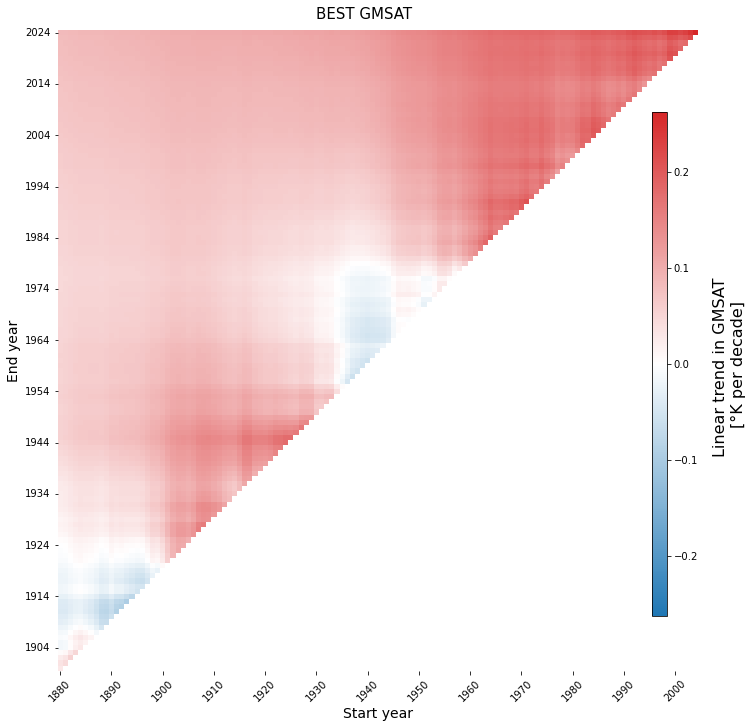

In [263]:
# plotting these trends

# first have to cut down the temp length
offset = 20 # years
trendsDfCrop = CropTrendsDf(trendsDf, offset)

# setting the colourbar
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
colors = [(0,'tab:blue'), (0.50,'white'), (1,'tab:red')]
cmap = mcolors.LinearSegmentedColormap.from_list('Blue_white_red', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig, ax = plt.subplots(figsize = (10,10), constrained_layout = True)
fig.suptitle(f'{obsName} GMSAT', fontsize = 15)

ax.set_aspect('equal')
plot = sns.heatmap(trendsDfCrop, cmap = cmap, vmin = vmin, vmax = vmax, ax = ax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
ax.tick_params(axis = 'x', rotation = 45)
ax.tick_params(axis = 'y', rotation = 0)
ax.set_ylabel('End year', fontsize = 14)
ax.set_xlabel('Start year', fontsize = 14)

cbarAx = fig.add_axes([0.9, 0.15, 0.02, 0.7])
colorBar = fig.colorbar(cm.ScalarMappable(norm = norm, cmap = cmap), cax = cbarAx)
colorBar.set_label('Linear trend in GMSAT \n[°K per decade]', rotation = 90, labelpad = 15, fontsize = 16)

plt.show()

## Signifance testing: generating white noise with the same mean and variance

In [264]:
# detrending the meanTemp time series to get the standard deviation | using 60 year low pass | these values seem to produce a line similar to the temp data

# ----------------------------
#      Defining the filter
# ----------------------------

# defining the cutoff frequency
cutoff = 60 # years
freqCutoff = 1/cutoff

# defining the parameters for the filter
order = 3 # trying different values
fs = 1

# building the filter
b, a = butter(order, freqCutoff, btype = 'low', analog = False, output = 'ba', fs = fs)

# filtering
meanTempFilt = filtfilt(b, a, meanTemp)

# ----------------------------
#      Detrending the data
# ----------------------------

meanTempDetrended = meanTemp - meanTempFilt

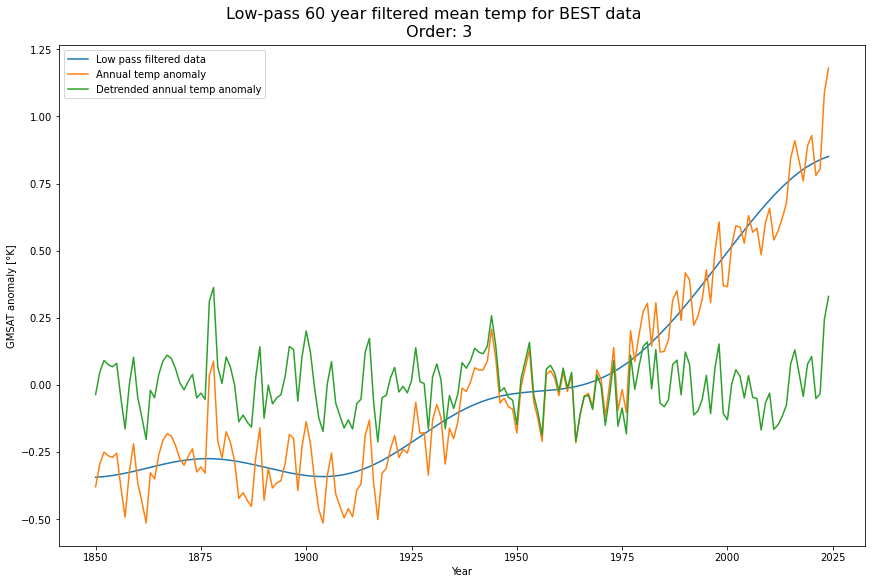

In [265]:
fig, ax = plt.subplots(figsize = (12,8), constrained_layout = True)
fig.suptitle(f'Low-pass {cutoff} year filtered mean temp for {obsName} data \n Order: {order}', fontsize = 16)
plt.plot(meanTemp.year, meanTempFilt, label = 'Low pass filtered data')
plt.plot(meanTemp.year, meanTemp, label = 'Annual temp anomaly')
plt.plot(meanTemp.year, meanTempDetrended, label = 'Detrended annual temp anomaly')
ax.set_ylabel('GMSAT anomaly [°K]')
ax.set_xlabel('Year')
plt.legend()

# saving this figure
MakeChangeDir(dirPlotsObs)
plt.savefig(f'Detrending_{obsName}.png')

plt.show()

## Creating Red and White Noise

In [204]:
# initialise dictionary to hold the trends
dictTrendsWN = defaultdict(list)
dictTrendsRN = defaultdict(list)

# calculating the meanTemp values
meanTempMean = meanTempDetrended.mean().item()
meanTempStd = meanTempDetrended.std().item()

# calculating the AR1 coefficient
numberPoints = len(meanTempDetrended.values)
AR1, pVal = pearsonr(meanTempDetrended.values[:numberPoints-1], meanTempDetrended.values[1:numberPoints])

In [ ]:
# creating red and white noise time series and calculating the trends for them

# initialise lists to hold the std and mean values as well
listMeanWN = []
listStdWN = []
listMeanRN = []
listStdRN = []

for n in range(N):

    # generate the time series
    whiteNoise = GenerateWN(meanTemp, meanTempMean, meanTempStd)
    redNoise = GenerateWN(meanTemp, meanTempMean, meanTempStd)

    # saving out the mean and std of both of these just to check that they were actually right
    listStdWN.append(whiteNoise.std().item())
    listMeanWN.append(whiteNoise.mean().item())
    listStdRN.append(redNoise.std().item())
    listMeanRN.append(redNoise.mean().item())

    # calculating trends on these
    trendsDfWN = Trend(whiteNoise).trendsDf
    trendsDfRN = Trend(redNoise).trendsDf
    
    # saving the trends to output files
    os.chdir(dirTrendsWN)
    fileName = (f'Trend_WN_{n}.csv')
    trendsDfWN.to_csv(fileName, index = True)

    os.chdir(dirTrendsRN)
    fileName = (f'Trend_RN_{n}.csv')
    trendsDfRN.to_csv(fileName, index = True)

    print(f'{n} / {N}')

# saving out the csv files
os.chdir(dirStats)

with open('Mean_WN.csv', 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(listMeanWN)
    
with open('STD_WN.csv', 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(listStdWN)
    
with open('Mean_RN.csv', 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(listMeanRN)
    
with open('STD_RN.csv', 'w', newline = '') as file:
    writer = csv.writer(file)
    writer.writerow(listStdRN)

## Reading files back in and calculating obs in range

In [266]:
# reading files back in
os.chdir(dirTrendsWN)
dictTrendsWN = TrendsDictFromFiles(dirTrendsWN)

os.chdir(dirTrendsRN)
dictTrendsRN = TrendsDictFromFiles(dirTrendsRN)

# calculate upper and lower values
dictLowerWN, dictUpperWN = CalculateTrendPercentile(dictTrendsWN, 2.5, 97.5)
dictLowerRN, dictUpperRN = CalculateTrendPercentile(dictTrendsRN, 2.5, 97.5)

# find the values in range
dictDataInRangeWN = FlagInRange(dictLowerWN, dictUpperWN, trendsDict)
dictDataInRangeRN = FlagInRange(dictLowerRN, dictUpperRN, trendsDict)

# convert to dataframes
dfDataInRangeWN = DictToDf(dictDataInRangeWN)
dfDataInRangeRN = DictToDf(dictDataInRangeRN)

### Plotting

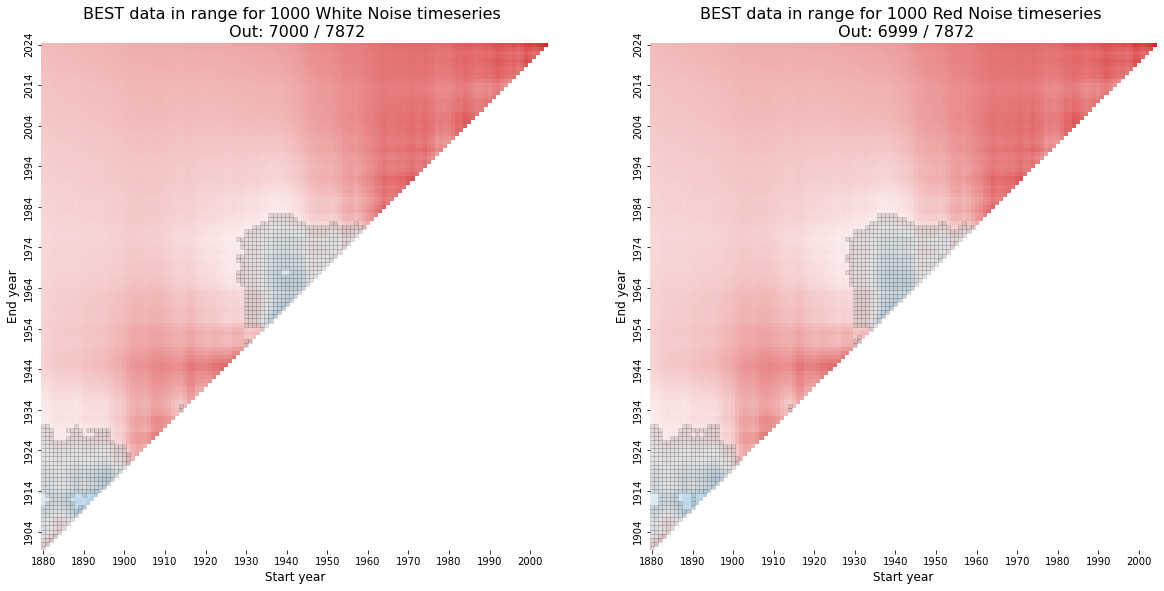

In [295]:
# plotting for in and out of range

# __Universal attributes___
nFigures = 2
nCols = nFigures

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (10, 10)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]

# trimming the obs data
offset = 20 # years
trendsDfCrop = CropTrendsDf(trendsDf, offset)

# setting the colourbar
vmin = trendsDf.min().min()
vmax = trendsDf.max().max()

# find the absolute values of these to make them symmetrical (if one is positive and the other is negative)
if (vmin < 0) & (vmax > 0):
    limit = max(abs(vmin), abs(vmax))
    vmin = -limit
    vmax = limit
    
colors = [(0,'tab:blue'), (0.50,'white'), (1,'tab:red')]
cmap = mcolors.LinearSegmentedColormap.from_list('Blue_white_red', colors)
norm = mcolors.Normalize(vmin = vmin, vmax = vmax)

fig, axes = plt.subplots(nRows, nCols, figsize = (figWidth, figHeight))

# counting data points in and out for both
countOutWN = list(dictDataInRangeWN.values()).count(0)
countAllWN = list(dictDataInRangeWN.values()).count(1) + countOutWN

countOutRN = list(dictDataInRangeRN.values()).count(0)
countAllRN = list(dictDataInRangeRN.values()).count(1) + countOutRN

# counting the number of time series involved
numberWN = len(dictTrendsWN[list(dictTrendsWN.keys())[0]])
numberRN = len(dictTrendsRN[list(dictTrendsRN.keys())[0]])

# ______________plotting white noise_______________

axes[0].set_aspect('equal')
axes[0].set_title(f'{obsName} data in range for {numberWN} White Noise timeseries \n Out: {countOutWN} / {countAllWN}', fontsize = 16)
plot = sns.heatmap(trendsDfCrop, cmap = cmap, ax = axes[0], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
axes[0].set_ylabel('End year', fontsize = 12)
axes[0].set_xlabel('Start year', fontsize = 12)

for a, row in enumerate(dfDataInRangeWN.values):
        for b, value in enumerate(row):
            if value == 1:
                plot.add_patch(plt.Rectangle((b, a), 1, 1, fill=True, color = 'black', edgecolor=None, alpha = 0.1))

#axes[0].contourf(dfDataInRangeWN,levels=[0.5, 1.5], colors='none', hatches=['////'], extend='lower')

# ______________plotting red noise_______________

axes[1].set_aspect('equal')
axes[1].set_title(f'{obsName} data in range for {numberRN} Red Noise timeseries \n Out: {countOutRN} / {countAllRN}', fontsize = 16)
plot = sns.heatmap(trendsDfCrop, cmap = cmap, ax = axes[1], vmin = vmin, vmax = vmax, xticklabels = 10, yticklabels = 10, center = 0, cbar = False, norm = norm)
axes[1].set_ylabel('End year', fontsize = 12)
axes[1].set_xlabel('Start year', fontsize = 12)

#axes[1].contourf(dfDataInRangeRN,levels=[0.5, 1.5], colors='black', extend='max', alpha = 0.3)
for a, row in enumerate(dfDataInRangeRN.values):
        for b, value in enumerate(row):
            if value == 1:
                plot.add_patch(plt.Rectangle((b, a), 1, 1, fill=True, color = 'black', edgecolor=None, alpha = 0.1))

MakeChangeDir(dirPlotsObs)
plt.savefig(f'SigTriangles_{N}_{obsName}.png')


plt.show()

### Looking at the stats

In [268]:
os.chdir(dirStats)
fileNames = ['Mean_WN.csv', 'Mean_RN.csv', 'STD_WN.csv', 'STD_RN.csv']
fields = ['Mean_WN', 'Mean_RN', 'STD_WN', 'STD_RN']

# creating a 2 d array to store the values
stats = pd.read_csv(fileNames[0], header = None)

for fileNum in range(1,len(fileNames)):
    file = pd.read_csv(fileNames[fileNum], header = None)
    stats = pd.concat([stats, file])

stats['Field'] = fields
stats = stats.set_index('Field', drop = True);

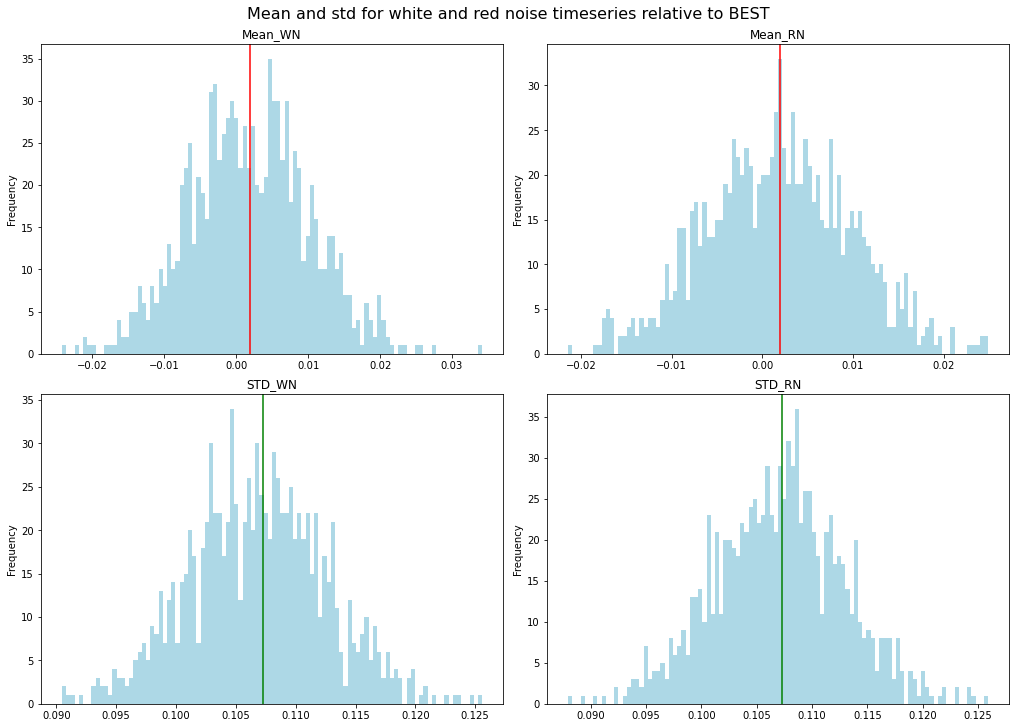

In [269]:
# plotting this and them mean values from the GISS dataset
fig, axes = plt.subplots(2,2, figsize = (14,10), constrained_layout = True)
axes_flat = axes.flatten()
fig.suptitle('Mean and std for white and red noise timeseries relative to BEST', fontsize = 16)

for i in range(len(fileNames)):
    axes_flat[i].set_title(fields[i], fontsize = 12)
    stats.iloc[i].plot.hist(ax = axes_flat[i], color = 'lightblue', bins = 100)
    
# getting the values from the real dataset
meanTempMean = meanTempDetrended.mean().item()
meanTempStd = meanTempDetrended.std().item()

# plotting these as reference lines
axes_flat[0].axvline(x = meanTempMean, color = 'r')
axes_flat[1].axvline(x = meanTempMean, color = 'r')
axes_flat[2].axvline(x = meanTempStd, color = 'g')
axes_flat[3].axvline(x = meanTempStd, color = 'g')

MakeChangeDir(dirPlotsObs)
plt.savefig(f'RNWNStats_{N}_{obsName}.png')

plt.show()

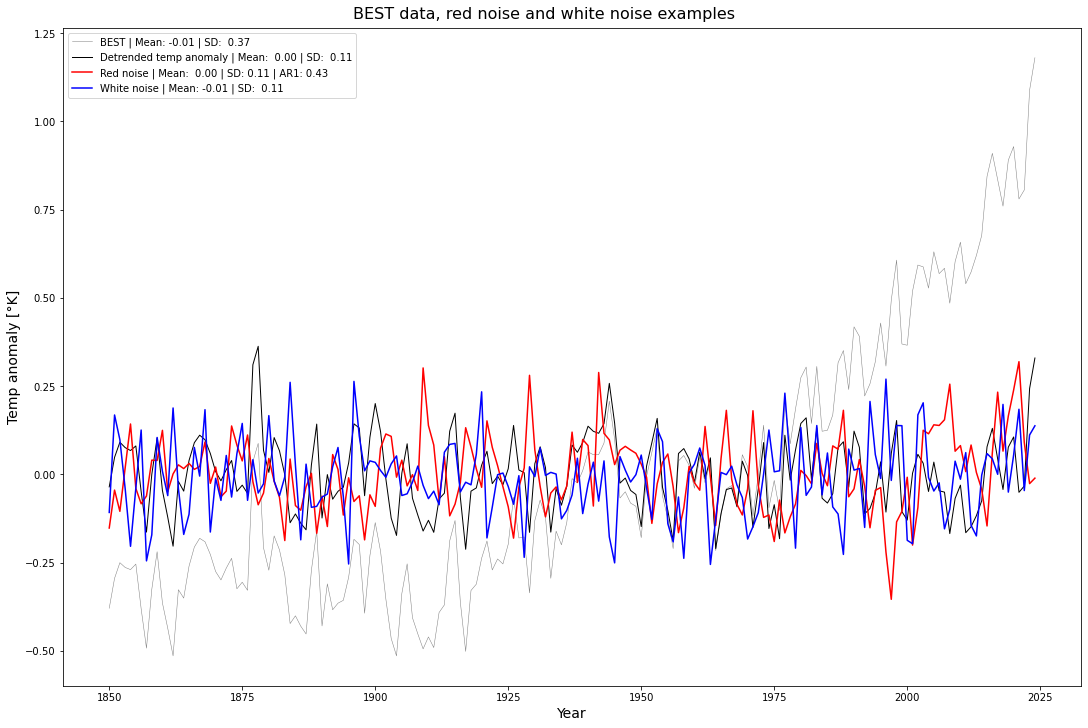

In [270]:
fig, ax = plt.subplots(figsize = (15,10), constrained_layout = True)
fig.suptitle(f'{obsName} data, red noise and white noise examples', fontsize = 16)

meanTemp.plot(label = f'{obsName} | Mean: {meanTemp.mean().item():.2f} | SD: {meanTemp.std().item(): .2f}', color = 'gray', linewidth = 0.5)
meanTempDetrended.plot(label = f'Detrended temp anomaly | Mean: {meanTempMean: .2f} | SD: {meanTempStd: .2f}', color = 'black', linewidth = 1)
plotRN = GenerateRN(meanTempMean, meanTempStd, AR1, meanTempDetrended.year)
plotRN.plot(label = f'Red noise | Mean: {plotRN.mean().item(): .2f} | SD: {plotRN.std().item() :.2f} | AR1: {AR1:.2f}', color = 'red', linewidth = 1.5)
plotWN = GenerateWN(meanTempMean, meanTempStd, meanTempDetrended.year)
plotWN.plot(label = f'White noise | Mean: {plotWN.mean().item():.2f} | SD: {plotWN.std().item(): .2f}', color = 'blue', linewidth = 1.5)

ax.set_xlabel('Year', fontsize = 14)
ax.set_ylabel('Temp anomaly [°K]', fontsize = 14)
plt.legend()

MakeChangeDir(dirPlotsObs)
plt.savefig(f'ExampleNoise_{obsName}.png')

plt.show()

## Investigating trends of specific lengths to see if this seems to be working

Jason and Richard think that the trends seem unusual (i.e., they wouldn't expect only the negative trend values to be the ones that are in range; investigating here the 20 year trends to see if the actual ones do appear to be in the 95% range or not. 

In [271]:
# create a list of the keys that are X years apart (i.e., tuples)
# setting constants
trendLength = 20

#---------------------
#    RED NOISE
#---------------------

# finding the first start date and last start date
startFirstRN = min([date[0] for date in list(dictTrendsRN.keys())])
startLastRN = max([date[0] for date in list(dictTrendsRN.keys())])

# creating end dates for the whole range
datesListRN = []
for yearStart in np.arange(startFirstRN, startLastRN+1):
    tupleDate = (yearStart, yearStart + trendLength)
    datesListRN.append(tupleDate)

# now iterate through this list of tuples as keys for the major dictTrends and append those to a list of trends
listHistTrendsRN = [] # list to hold the trends for the histogram

for dates in datesListRN:
    listHistTrendsRN += dictTrendsRN[dates]
    
#---------------------
#    WHITE NOISE
#---------------------
# finding the first start date and last start date
startFirstWN = min([date[0] for date in list(dictTrendsWN.keys())])
startLastWN = max([date[0] for date in list(dictTrendsWN.keys())])

# creating end dates for the whole range
datesListWN = []
for yearStart in np.arange(startFirstWN, startLastWN+1):
    tupleDate = (yearStart, yearStart + trendLength)
    datesListWN.append(tupleDate)

# now iterate through this list of tuples as keys for the major dictTrends and append those to a list of trends
listHistTrendsWN = [] # list to hold the trends for the histogram

for dates in datesListWN:
    listHistTrendsWN += dictTrendsWN[dates]
    
#---------------------
#    MODEL
#---------------------
# using the same dates as the white and red noise

# iterate through the dictionary and save the trends for this period
listHistTrendsModel = []

for dates in datesListWN:
    listHistTrendsModel.append(trendsDict[dates])

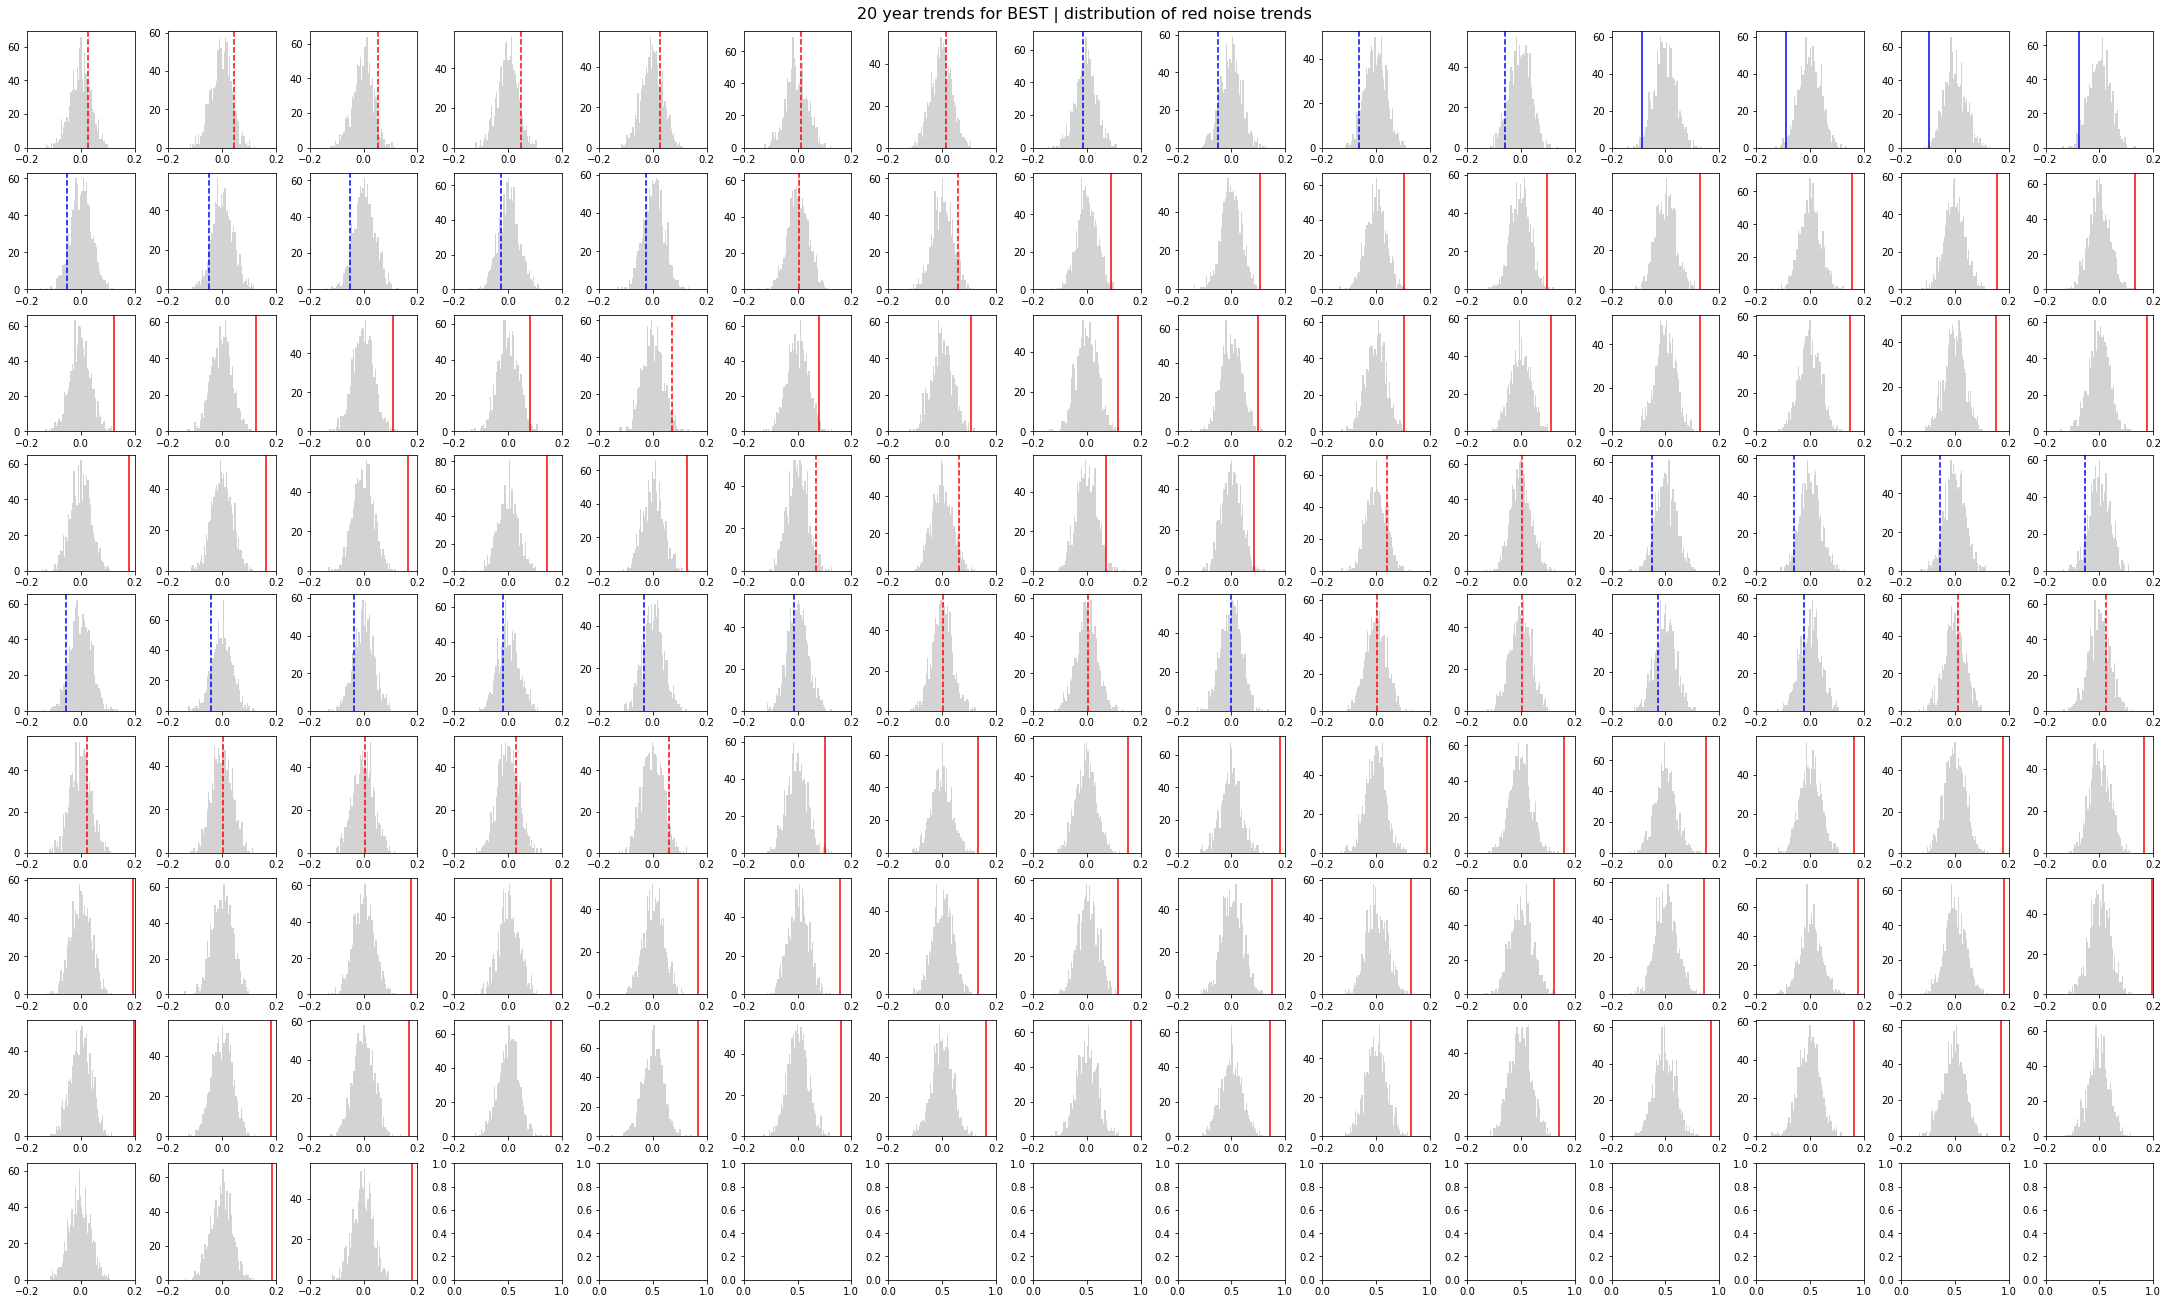

In [274]:
# __Universal attributes___
nFigures = len(datesListRN)

nCols = 15

if nFigures % nCols == 0:
    nRows = int(nFigures/nCols)
else:
    nRows = int(np.floor(nFigures/nCols) + 1)

subplotSize = (2, 2)
figWidth = nCols * subplotSize[0]
figHeight = nRows * subplotSize[1]

fig, axes = plt.subplots(ncols = nCols, nrows = nRows, figsize = (figWidth, figHeight), constrained_layout = True)
axesFlat = axes.flatten()
fig.suptitle(f'{trendLength} year trends for {obsName} | distribution of red noise trends', fontsize = 16)

# looping through and plotting the histogram for each point
# counting the sig values
countSig = 0
countNonSig = 0

for i, dates in enumerate(datesListRN):
    trendsNoise = dictTrendsRN[dates]
    trendModel = trendsDict[dates]
    
    if (trendModel <= np.percentile(trendsNoise, 2.5)) | (trendModel >= np.percentile(trendsNoise, 97.5)):
        sigMarker = '-'
        countSig += 1
    else:
        sigMarker = '--'
        countNonSig += 1
    
    if trendModel > 0:
        signColor = 'red'
    else:
        signColor = 'blue'

    axesFlat[i].hist(dictTrendsRN[dates], bins = 50, color = 'lightgray')
    axesFlat[i].axvline(trendsDict[dates], color = signColor, linestyle = sigMarker)
    axesFlat[i].set_xlim([-0.20, 0.20])
    
    
# saving plot
MakeChangeDir(dirPlotsObs)
plt.savefig(f'{trendLength}YR_trends_hist_{obsName}.png')

## Another approach: plotting the 20 year trends with the 95% envelope

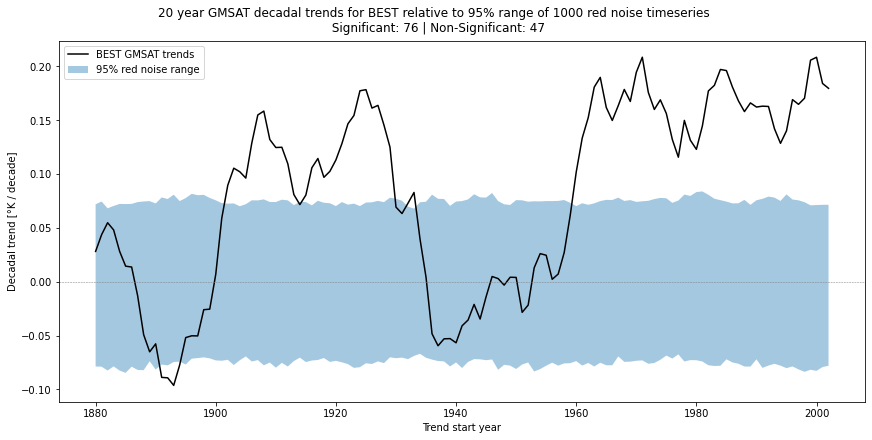

In [273]:
plotDates = np.arange(startFirstRN, startLastRN+1)

# finding upper and lower bounds
upperBounds = []
lowerBounds = []
for dates in datesListRN:
    upperBounds.append(np.percentile(dictTrendsRN[dates], 97.5))
    lowerBounds.append(np.percentile(dictTrendsRN[dates], 2.5))

# counting the number of significant points
countSig = 0
countNonSig = 0

for i, trend in enumerate(listHistTrendsModel):
    if (trend <= lowerBounds[i]) | (trend >= upperBounds[i]):
        countSig += 1
    else:
        countNonSig += 1

fig, axes = plt.subplots(figsize = (12,6), constrained_layout = True)
fig.suptitle(f'{trendLength} year GMSAT decadal trends for {obsName} relative to 95% range of {N} red noise timeseries \n Significant: {countSig} | Non-Significant: {countNonSig}')
axes.set_xlabel('Trend start year')
axes.set_ylabel('Decadal trend [°K / decade]')
plt.plot(plotDates, listHistTrendsModel, color = 'black', label = f'{obsName} GMSAT trends')
plt.fill_between(plotDates, lowerBounds, upperBounds, alpha = 0.4, label = f'95% red noise range')
plt.axhline(y = 0, color = 'gray', linewidth = 0.5, linestyle = '--')
plt.legend()

# saving this figure
MakeChangeDir(dirPlotsObs)
plt.savefig(f'{trendLength}YR_trends_line_{obsName}.png')

plt.show()